In [1]:
import os
import sys
os.getcwd()

'c:\\Users\\ebaca\\Desktop\\Soc-225\\Final Project'

In [2]:
# importing libraries & making torch.device object for GPU

# neural network packages
import torch
import torch.nn as nn
from torch.nn import Transformer
from torch import Tensor
from torch.utils.data import DataLoader, Dataset

# data packages
import h5py
import numpy as np
import math
import pandas as pd
import sklearn.preprocessing as prep
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
import random
from concurrent.futures import ThreadPoolExecutor
from sklearn.preprocessing import StandardScaler

# visual packages
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tqdm.notebook as tq
from tqdm.notebook import trange
import warnings

# Create a torch.device object to tell pytorch where to store your tensors: cpu or gpu
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
hdf = h5py.File('../../Data/CCSN_Pan_SNR_Free.h5', 'r')

signals = {
    'NR': hdf['Model_NR']['Hp'], # NR: No Rotation
    'SR': hdf['Model_SR']['Hp'], # SR: Slow Rotation
    'FR': hdf['Model_FR']['Hp'], # FR: Fast Rotation
    'Noise': hdf['Noise']['Strain']
}

signals['NR'].shape, signals['SR'].shape, signals['FR'].shape, signals['Noise'].shape

((50000, 8192), (50000, 8192), (50000, 8192), (150000, 8192))

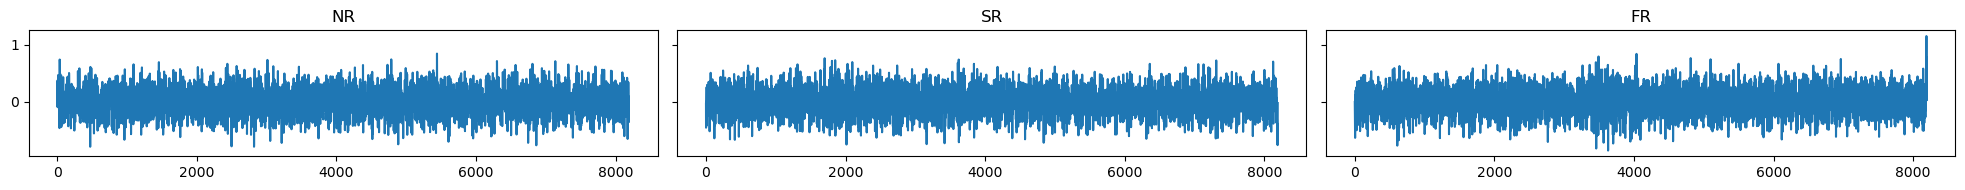

In [4]:
''' 
signal types (classes)
    - NR: No Rotation
    - SR: Slow Rotation
    - FR: Fast Rotation
    - Noise

one sample 
    - classified as a signal type (NR, SR, FR) or noise
    - array of shape 8192 x 1 (strain measurements)

50k samples of each class
''';

fig, axs = plt.subplots(1, 3, figsize=(20, 2), sharex=True, sharey=True)

axs[0].plot(signals['NR'][0])
axs[0].set_title('NR')

axs[1].plot(signals['SR'][0])
axs[1].set_title('SR')

axs[2].plot(signals['FR'][0])
axs[2].set_title('FR')

plt.tight_layout()
plt.show()

In [5]:
import torch
from torch.utils.data import DataLoader, Dataset, ConcatDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class SignalDataset(Dataset):
    def __init__(self, signals, signal_type):
        data_np = np.array(signals[signal_type])
        self.data = torch.tensor(data_np, dtype=torch.float32)
        self.labels = torch.tensor([0 if signal_type == 'NR' else 1 if signal_type == 'SR' else 2 for _ in range(len(data_np))], dtype=torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# Create datasets
print('creating datasets')
nr_dataset = SignalDataset(signals, 'NR')
sr_dataset = SignalDataset(signals, 'SR')
fr_dataset = SignalDataset(signals, 'FR')
noise_dataset = SignalDataset(signals, 'Noise')

# Combine datasets
print('combining datasets')
full_dataset = ConcatDataset([nr_dataset, sr_dataset, fr_dataset, noise_dataset])

# Create DataLoader
print('creating DataLoader')
batch_size = 64
data_loader = DataLoader(full_dataset, batch_size=batch_size, shuffle=True)

# Define the model
class SignalClassifier(nn.Module):
    def __init__(self):
        super(SignalClassifier, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=5)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 2045, 128)  # Adjust based on input size after convolution
        self.fc2 = nn.Linear(128, 3)  # Three output classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 2045)  # Flatten layer
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate and move the model to GPU
model = SignalClassifier().to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train(model, data_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.unsqueeze(1)  # Add channel dimension
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch + 1}, Loss: {running_loss / len(data_loader)}')

# Train the model
print('training model')
train(model, data_loader, criterion, optimizer)


creating datasets
combining datasets
creating DataLoader
training model
Epoch 1, Loss: 0.34130675942754635
Epoch 2, Loss: 0.2479932501033241
Epoch 3, Loss: 0.18471271641005732
Epoch 4, Loss: 0.11522904604558361
Epoch 5, Loss: 0.07059405122063347
Epoch 6, Loss: 0.045757047587019754
Epoch 7, Loss: 0.03407417707403076
Epoch 8, Loss: 0.029659653665404677
Epoch 9, Loss: 0.02412248557072289
Epoch 10, Loss: 0.02173062393692308


In [6]:
hdf_test = h5py.File('../../Data/GW1_CCSN_Pan_SNR_Free_Test_Validation.h5', 'r')

test_signals = {
    'NR': hdf_test['Model_NR']['Hp'], # NR: No Rotation
    'SR': hdf_test['Model_SR']['Hp'], # SR: Slow Rotation
    'FR': hdf_test['Model_FR']['Hp'], # FR: Fast Rotation
    'Noise': hdf_test['Noise']['Strain']
}

nr_test_dataset = SignalDataset(test_signals, 'NR')
sr_test_dataset = SignalDataset(test_signals, 'SR')
fr_test_dataset = SignalDataset(test_signals, 'FR')
noise_test_dataset = SignalDataset(test_signals, 'Noise')

test_dataset = ConcatDataset([nr_test_dataset, sr_test_dataset, fr_test_dataset, noise_test_dataset])
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

def evaluate(model, data_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    running_loss = 0.0

    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.unsqueeze(1)  # Add channel dimension
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    avg_loss = running_loss / len(data_loader)
    return accuracy, avg_loss

# Evaluate the model
test_accuracy, test_loss = evaluate(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


Test Loss: 0.8653, Test Accuracy: 0.8953
